In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pydotplus
from scipy.cluster import hierarchy
import seaborn as sns
from sklearn import decomposition, preprocessing, cluster, tree
#from yellowbrick.cluster.silhouette import SilhouetteVisualizer


import io
import urllib.request as req
import zipfile


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import tree

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### DATA EXPLORATION

In [ ]:
df=pd.read_excel('CS_68_data_set.xlsx')#, index_col='token')
sp=pd.read_excel('CS_68_data_set_spanish.xlsx')#,  index_col='token')
p=pd.read_excel('CS68_properties.xlsx')#, index_col='token')
i=pd.read_excel('CS68_improvements.xlsx')

In [ ]:
df.drop(columns=['MAX(p.original_bid_amount)', 'MAX(p.entered_construction_stage_contract_amount)', 'company_created_date', 'line_2'], inplace = True)

In [ ]:
df.head()


,token,city,zipcode,App Date,Approval Date,company_name,company_status,DWELLING UNIT SIZE,DWELLING TYPE,ESTIMATED HOUSEHOLD INCOME RANGE CODE V6,EST HOUSEHOLD INCOME V5,NUMBER OF PERSONS IN LIVING UNIT,NUMBER OF ADULTS IN LIVING UNIT,MOR BANK: POLITICAL CONTRIBUTOR,PROPERTY-REALTY: HOME YEAR BUILT,MOSAIC HOUSEHOLD,HOUSEHOLD COMPOSITION,CAPE: EDUC: ISPSA,id,Right_token,avg(year(now()) - year(hpo.date_of_birth)),county,district,current_contract,maximum_contract,improvements_total
0,223DGC,WALNUT CREEK,94597,2020-02-28 21:32:53,2020-02-28 21:41:44,Service Champions - Norcal,Active,A,S,D,K,2,2,0,1978.0,C13,H,4601,1907050,223DGC,54.0,Contra Costa,Walnut Creek,20900.0,86777.64,20900.0
1,223EG6,STOCKTON,95209,2018-06-12 23:27:07,2016-04-16 23:47:28,Quality First Home Improvement Inc,Active,A,S,J,B,2,1,0,1975.0,I33,E,2926,279199,223EG6,45.0,San Joaquin,Stockton,12000.0,32075.32,0.0
2,223NKZ,SACRAMENTO,95828,2017-03-20 19:51:39,2017-03-20 20:04:11,Ketsavong Construction Company,Terminated,A,S,F,G,6,4,0,1988.0,F23,I,3299,668353,223NKZ,29.0,Sacramento,Sacramento County Unincorporated,15790.0,51392.95,15790.0
3,223NRE,NORTH HIGHLANDS,95660,2020-03-05 21:00:03,NaT,Service Champions - Norcal,Active,A,S,E,A,2,2,0,1961.0,P59,C,2607,1911341,223NRE,28.0,Sacramento,Sacramento County Unincorporated,22954.0,39486.98,22954.0
4,2262Y3,BELLFLOWER,90706,2018-12-10 22:47:16,NaT,Canopy Energy - SO CAL,Active,A,S,F,E,1,1,0,1941.0,I32,B,3608,1576007,2262Y3,55.0,Los Angeles,Bellflower,0.0,0.00,54450.0


In [ ]:
# dependent variable is 'Company Status'. If Company is terminated, it means it had some fraudulent activity in the past
df.company_status.value_counts()

Active        15445
Terminated     6149
Name: company_status, dtype: int64

**Exploring Mosaic Household segments.**
Experian's Mosaic® USA is a household-based consumer lifestyle segmentation system that classifies all U.S. households and neighborhoods into 71 unique types and 19 overarching groups, providing a 360-degree view of consumers' choices, preferences and habits.

In [ ]:
len(df['MOSAIC HOUSEHOLD'].unique())

72

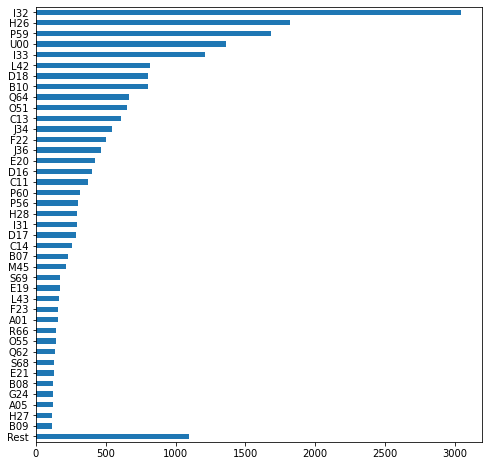

In [ ]:
top_mosaic=df['MOSAIC HOUSEHOLD'].value_counts()
limit = 40
ax = (
    pd.concat([top_mosaic.iloc[:limit], 
               pd.Series(top_mosaic.iloc[limit:].sum(), index=['Rest'])])
    .iloc[::-1]
    .plot.barh(figsize=(8, 8))
)

In [ ]:
i.head(10)

,id,token,improvement_type,improvement
0,1522366,PXH2TP,"Windows, Doors, and Skylights",Additional building openings to provide natura...
1,487299,2RM2FY,"Windows, Doors, and Skylights",Additional building openings to provide natura...
2,1894722,4HA7NP,"Windows, Doors, and Skylights",Additional building openings to provide natura...
3,551750,JAV6RT,"Windows, Doors, and Skylights",Additional building openings to provide natura...
4,1315710,AHA6XZ,"Windows, Doors, and Skylights",Additional building openings to provide natura...
5,1325502,FRPDWP,"Windows, Doors, and Skylights",Additional building openings to provide natura...
6,1133427,4GWGWW,"Windows, Doors, and Skylights",Additional building openings to provide natura...
7,1979908,6TVX2J,"Windows, Doors, and Skylights",Additional building openings to provide natura...
8,1984499,N6AGF4,"Windows, Doors, and Skylights",Additional building openings to provide natura...
9,1488291,WYHAH2,"Windows, Doors, and Skylights",Additional building openings to provide natura...


In [ ]:
imp=pd.get_dummies(i[['token', 'improvement_type']].set_index('token'), drop_first=True).groupby(['token'], as_index=True).sum()

In [ ]:
imp=imp.apply(lambda x: np.where(x > 1, 1, x))

In [ ]:
imp.head()

,improvement_type_Building Envelope,improvement_type_HVAC,improvement_type_High-Efficiency Lighting and Appliances,improvement_type_High-Efficiency Lighting and Applicances,improvement_type_High-Efficiency Pool Equipment,improvement_type_High-Efficiency Water Heating,improvement_type_Indoor Water Efficiency,improvement_type_Other,improvement_type_Outdoor Water Efficiency,improvement_type_Seismic Retrofit,improvement_type_Solar Photovoltaic,improvement_type_Solar Thermal,"improvement_type_Windows, Doors, and Skylights"
token,,,,,,,,,,,,,
273943,1,0,0,0,0,0,0,0,0,0,0,0,0
369632,0,1,0,0,0,0,0,0,0,0,0,0,0
464266,0,0,0,0,0,0,0,0,0,0,0,0,1
466947,0,0,0,0,0,0,0,0,0,0,0,0,1
499729,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
df=pd.merge(df, sp, on='token', how = 'inner')

In [ ]:
df=pd.merge(df, p, on='token', how = 'inner')

In [ ]:
df=pd.merge(df, imp, on='token', how = 'inner')

In [ ]:
df.head()

,token,city,zipcode,App Date,Approval Date,company_name,company_status,DWELLING UNIT SIZE,DWELLING TYPE,ESTIMATED HOUSEHOLD INCOME RANGE CODE V6,EST HOUSEHOLD INCOME V5,NUMBER OF PERSONS IN LIVING UNIT,NUMBER OF ADULTS IN LIVING UNIT,MOR BANK: POLITICAL CONTRIBUTOR,PROPERTY-REALTY: HOME YEAR BUILT,MOSAIC HOUSEHOLD,HOUSEHOLD COMPOSITION,CAPE: EDUC: ISPSA,id,Right_token,avg(year(now()) - year(hpo.date_of_birth)),county,district,current_contract,maximum_contract,improvements_total,spanish_docs_enabled,fair_market_value,year_built,building_area,improvement_type_Building Envelope,improvement_type_HVAC,improvement_type_High-Efficiency Lighting and Appliances,improvement_type_High-Efficiency Lighting and Applicances,improvement_type_High-Efficiency Pool Equipment,improvement_type_High-Efficiency Water Heating,improvement_type_Indoor Water Efficiency,improvement_type_Other,improvement_type_Outdoor Water Efficiency,improvement_type_Seismic Retrofit,improvement_type_Solar Photovoltaic,improvement_type_Solar Thermal,"improvement_type_Windows, Doors, and Skylights"
0,223DGC,WALNUT CREEK,94597,2020-02-28 21:32:53,2020-02-28 21:41:44,Service Champions - Norcal,Active,A,S,D,K,2,2,0,1978.0,C13,H,4601,1907050,223DGC,54.0,Contra Costa,Walnut Creek,20900.0,86777.64,20900.0,0.0,873080.0,1978.0,1893.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,223NKZ,SACRAMENTO,95828,2017-03-20 19:51:39,2017-03-20 20:04:11,Ketsavong Construction Company,Terminated,A,S,F,G,6,4,0,1988.0,F23,I,3299,668353,223NKZ,29.0,Sacramento,Sacramento County Unincorporated,15790.0,51392.95,15790.0,0.0,372160.0,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0
2,223NRE,NORTH HIGHLANDS,95660,2020-03-05 21:00:03,NaT,Service Champions - Norcal,Active,A,S,E,A,2,2,0,1961.0,P59,C,2607,1911341,223NRE,28.0,Sacramento,Sacramento County Unincorporated,22954.0,39486.98,22954.0,1.0,338881.0,1961.0,1733.0,1,1,0,0,0,0,0,0,0,0,0,0,0
3,2262Y3,BELLFLOWER,90706,2018-12-10 22:47:16,NaT,Canopy Energy - SO CAL,Active,A,S,F,E,1,1,0,1941.0,I32,B,3608,1576007,2262Y3,55.0,Los Angeles,Bellflower,0.0,0.00,54450.0,0.0,809000.0,1941.0,3948.0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,226NCV,SACRAMENTO,95822,2017-10-14 22:28:45,2017-10-14 22:36:28,AFFORDABLE COMPUTER SERVICES,Terminated,A,S,E,B,1,1,0,1960.0,S69,B,2526,1215780,226NCV,54.0,Sacramento,Sacramento City,6497.0,23023.73,6497.0,0.0,222360.0,1960.0,1018.0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Creating bulean for Terminated/Active that will be used as a classifier 

In [ ]:
df.company_status = df.company_status.replace({'Terminated':1, 'Active':0})

In [ ]:
#df.county.value_counts()

**ONLY LA projects will be used**


In [ ]:
df=df[df.county=='Los Angeles']

In [ ]:
# 1 - Terminated 0 - Active

In [ ]:
df.company_status.value_counts()

1    2278
0    1921
Name: company_status, dtype: int64

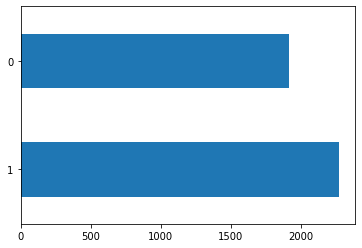

In [ ]:
df.company_status.value_counts().plot.barh()

In [ ]:
df.rename(columns={'avg(year(now()) - year(hpo.date_of_birth))':'age'}, inplace = True)


In [ ]:
#creating 'contract_precent' column. Sometimes contractors can take advantage of the max approved amount and try to push the project amount to the top 
df=df[df['current_contract']!=0]
df['contract_precent']=df['current_contract']/df['maximum_contract']*100
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
df.describe()

,zipcode,company_status,NUMBER OF PERSONS IN LIVING UNIT,NUMBER OF ADULTS IN LIVING UNIT,MOR BANK: POLITICAL CONTRIBUTOR,PROPERTY-REALTY: HOME YEAR BUILT,CAPE: EDUC: ISPSA,id,age,current_contract,maximum_contract,improvements_total,spanish_docs_enabled,fair_market_value,year_built,building_area,improvement_type_Building Envelope,improvement_type_HVAC,improvement_type_High-Efficiency Lighting and Appliances,improvement_type_High-Efficiency Lighting and Applicances,improvement_type_High-Efficiency Pool Equipment,improvement_type_High-Efficiency Water Heating,improvement_type_Indoor Water Efficiency,improvement_type_Other,improvement_type_Outdoor Water Efficiency,improvement_type_Seismic Retrofit,improvement_type_Solar Photovoltaic,improvement_type_Solar Thermal,"improvement_type_Windows, Doors, and Skylights",contract_precent
count,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3896.000000,3948.000000,3.948000e+03,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3.948000e+03,2215.000000,2220.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3948.000000,3587.000000
mean,91014.529635,0.546353,2.483283,2.154509,0.040527,1945.367813,2747.360182,1.252233e+06,57.197408,32752.106505,63250.000542,34404.080514,0.196049,5.655330e+05,1951.851919,1677.763063,0.547872,0.173506,0.083080,0.009372,0.001520,0.069402,0.077001,0.008359,0.090932,0.002280,0.173759,0.001013,0.329281,65.462308
std,1158.930112,0.497910,1.813435,1.529687,0.309267,22.917085,642.614518,3.643007e+05,14.805040,23226.620244,41246.451933,23856.849095,0.397056,3.132890e+05,25.442297,686.813420,0.497766,0.378732,0.276038,0.096366,0.038959,0.254169,0.266627,0.091054,0.287549,0.047697,0.378950,0.031818,0.470012,282.738337
min,90001.000000,0.000000,0.000000,0.000000,0.000000,1900.000000,1457.000000,2.770060e+05,24.000000,1.000000,0.000000,2850.000000,0.000000,0.000000e+00,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.950253
25%,90043.000000,0.000000,1.000000,1.000000,0.000000,1924.000000,2235.000000,1.006572e+06,47.500000,14297.000000,37945.435000,15512.000000,0.000000,4.464000e+05,1927.000000,1280.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.344127
50%,90706.000000,1.000000,2.000000,2.000000,0.000000,1949.000000,2628.000000,1.237679e+06,58.000000,25200.000000,65355.940000,26365.500000,0.000000,5.410000e+05,1953.000000,1536.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.718954
75%,91344.000000,1.000000,3.000000,3.000000,0.000000,1959.000000,3130.000000,1.459879e+06,67.500000,48000.000000,86413.830000,48000.000000,0.000000,6.589500e+05,1971.000000,1834.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,91.321670
max,93536.000000,1.000000,8.000000,8.000000,7.000000,2015.000000,5010.000000,2.016441e+06,103.000000,224740.730000,650964.170000,235000.000000,1.000000,6.430000e+06,2015.000000,10312.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12728.693274


In [ ]:
data=df[['token', 'age', 'county', 'company_status', 'CAPE: EDUC: ISPSA', 'NUMBER OF ADULTS IN LIVING UNIT','EST HOUSEHOLD INCOME V5', 
      'MOSAIC HOUSEHOLD', 'PROPERTY-REALTY: HOME YEAR BUILT', 'spanish_docs_enabled', 'fair_market_value', 'improvement_type_Building Envelope',
       'improvement_type_HVAC',
       'improvement_type_High-Efficiency Lighting and Appliances',
       'improvement_type_High-Efficiency Lighting and Applicances',
       'improvement_type_High-Efficiency Pool Equipment',
       'improvement_type_High-Efficiency Water Heating',
       'improvement_type_Indoor Water Efficiency', 'improvement_type_Other',
       'improvement_type_Outdoor Water Efficiency',
       'improvement_type_Seismic Retrofit',
       'improvement_type_Solar Photovoltaic', 'improvement_type_Solar Thermal',
       'improvement_type_Windows, Doors, and Skylights', 'company_status', 'contract_precent', 'district']]

In [ ]:
data.isnull().mean()

token                                                        0.000000
age                                                          0.000000
county                                                       0.000000
CAPE: EDUC: ISPSA                                            0.000000
NUMBER OF ADULTS IN LIVING UNIT                              0.000000
EST HOUSEHOLD INCOME V5                                      0.000000
MOSAIC HOUSEHOLD                                             0.000000
PROPERTY-REALTY: HOME YEAR BUILT                             0.012384
spanish_docs_enabled                                         0.000000
fair_market_value                                            0.000000
improvement_type_Building Envelope                           0.000000
improvement_type_HVAC                                        0.000000
improvement_type_High-Efficiency Lighting and Appliances     0.000000
improvement_type_High-Efficiency Lighting and Applicances    0.000000
improvement_type_Hig

In [ ]:
data.dropna(inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X=pd.get_dummies(data[['EST HOUSEHOLD INCOME V5', 'MOSAIC HOUSEHOLD', 'district']],  drop_first=True)

In [ ]:
X=X.join(data[['age','CAPE: EDUC: ISPSA','NUMBER OF ADULTS IN LIVING UNIT' , 'spanish_docs_enabled', 'improvement_type_Building Envelope',
       'improvement_type_HVAC',
       'improvement_type_High-Efficiency Lighting and Appliances',
       'improvement_type_High-Efficiency Lighting and Applicances',
       'improvement_type_High-Efficiency Pool Equipment',
       'improvement_type_High-Efficiency Water Heating',
       'improvement_type_Indoor Water Efficiency', 'improvement_type_Other',
       'improvement_type_Outdoor Water Efficiency',
       'improvement_type_Seismic Retrofit',
       'improvement_type_Solar Photovoltaic', 'improvement_type_Solar Thermal',
       'improvement_type_Windows, Doors, and Skylights', 'company_status', 'contract_precent' ]])

In [ ]:
y = X.pop('company_status')

In [ ]:
X.head()

,EST HOUSEHOLD INCOME V5_B,EST HOUSEHOLD INCOME V5_C,EST HOUSEHOLD INCOME V5_D,EST HOUSEHOLD INCOME V5_E,EST HOUSEHOLD INCOME V5_F,EST HOUSEHOLD INCOME V5_G,EST HOUSEHOLD INCOME V5_H,EST HOUSEHOLD INCOME V5_I,EST HOUSEHOLD INCOME V5_J,EST HOUSEHOLD INCOME V5_K,EST HOUSEHOLD INCOME V5_L,EST HOUSEHOLD INCOME V5_U,MOSAIC HOUSEHOLD_A02,MOSAIC HOUSEHOLD_A03,MOSAIC HOUSEHOLD_A04,MOSAIC HOUSEHOLD_A05,MOSAIC HOUSEHOLD_A06,MOSAIC HOUSEHOLD_B07,MOSAIC HOUSEHOLD_B08,MOSAIC HOUSEHOLD_B09,MOSAIC HOUSEHOLD_B10,MOSAIC HOUSEHOLD_C11,MOSAIC HOUSEHOLD_C12,MOSAIC HOUSEHOLD_C13,MOSAIC HOUSEHOLD_C14,MOSAIC HOUSEHOLD_D16,MOSAIC HOUSEHOLD_D17,MOSAIC HOUSEHOLD_D18,MOSAIC HOUSEHOLD_E19,MOSAIC HOUSEHOLD_E20,MOSAIC HOUSEHOLD_E21,MOSAIC HOUSEHOLD_F22,MOSAIC HOUSEHOLD_F23,MOSAIC HOUSEHOLD_G24,MOSAIC HOUSEHOLD_G25,MOSAIC HOUSEHOLD_H26,MOSAIC HOUSEHOLD_H27,MOSAIC HOUSEHOLD_H28,MOSAIC HOUSEHOLD_H29,MOSAIC HOUSEHOLD_I31,...,MOSAIC HOUSEHOLD_L42,MOSAIC HOUSEHOLD_L43,MOSAIC HOUSEHOLD_M45,MOSAIC HOUSEHOLD_N48,MOSAIC HOUSEHOLD_O51,MOSAIC HOUSEHOLD_O52,MOSAIC HOUSEHOLD_O53,MOSAIC HOUSEHOLD_O54,MOSAIC HOUSEHOLD_O55,MOSAIC HOUSEHOLD_P56,MOSAIC HOUSEHOLD_P57,MOSAIC HOUSEHOLD_P58,MOSAIC HOUSEHOLD_P59,MOSAIC HOUSEHOLD_P60,MOSAIC HOUSEHOLD_P61,MOSAIC HOUSEHOLD_Q62,MOSAIC HOUSEHOLD_Q64,MOSAIC HOUSEHOLD_Q65,MOSAIC HOUSEHOLD_R66,MOSAIC HOUSEHOLD_R67,MOSAIC HOUSEHOLD_S68,MOSAIC HOUSEHOLD_S69,MOSAIC HOUSEHOLD_U00,age,CAPE: EDUC: ISPSA,NUMBER OF ADULTS IN LIVING UNIT,spanish_docs_enabled,improvement_type_Building Envelope,improvement_type_HVAC,improvement_type_High-Efficiency Lighting and Appliances,improvement_type_High-Efficiency Lighting and Applicances,improvement_type_High-Efficiency Pool Equipment,improvement_type_High-Efficiency Water Heating,improvement_type_Indoor Water Efficiency,improvement_type_Other,improvement_type_Outdoor Water Efficiency,improvement_type_Seismic Retrofit,improvement_type_Solar Photovoltaic,improvement_type_Solar Thermal,"improvement_type_Windows, Doors, and Skylights"
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,55.0,3608,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81.0,2642,6,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51.0,3937,2,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1
15,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48.0,3144,1,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
17,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87.0,1927,4,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0


Splitting the data on training and test sets


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Logistic Regression

In [ ]:
# fit a model
clf = LogisticRegression(penalty='l2').fit(X_train, y_train)
# predict probabilities
predictions = clf.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
roc_auc_score(y_test, predictions)

0.8054752066115702

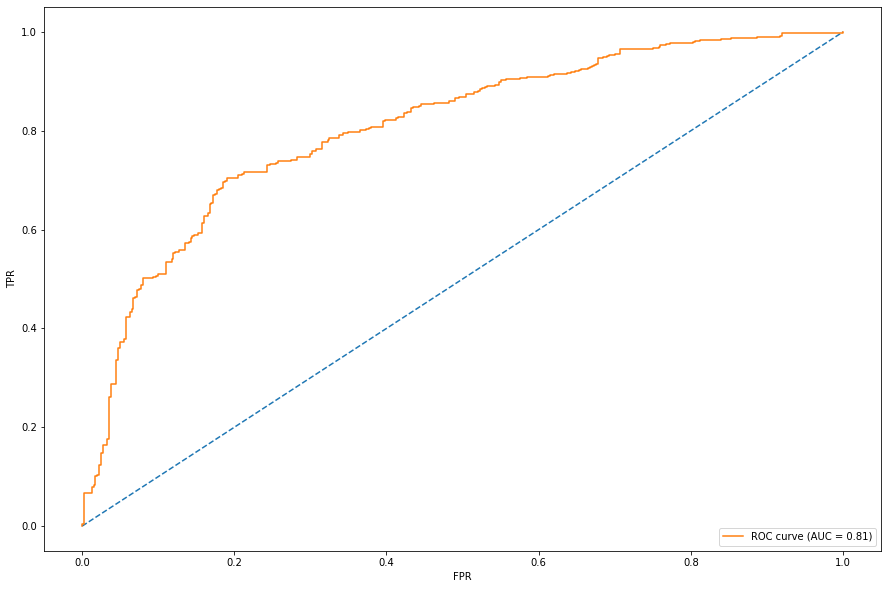

In [ ]:
# calculate scores
auc = roc_auc_score(y_test, predictions)

# calculate roc curves
fpr, tpr, _ = roc_curve(y_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predictions)
print('AUC: ', metrics.auc(fpr, tpr))
print(classification_report(y_test, predictions.round()))
print(confusion_matrix(y_test, predictions.round()))

AUC:  0.8054752066115702
              precision    recall  f1-score   support

           0       0.70      0.74      0.72       400
           1       0.78      0.74      0.76       484

    accuracy                           0.74       884
   macro avg       0.74      0.74      0.74       884
weighted avg       0.74      0.74      0.74       884

[[297 103]
 [126 358]]


Logistic Regression: Feature Importance


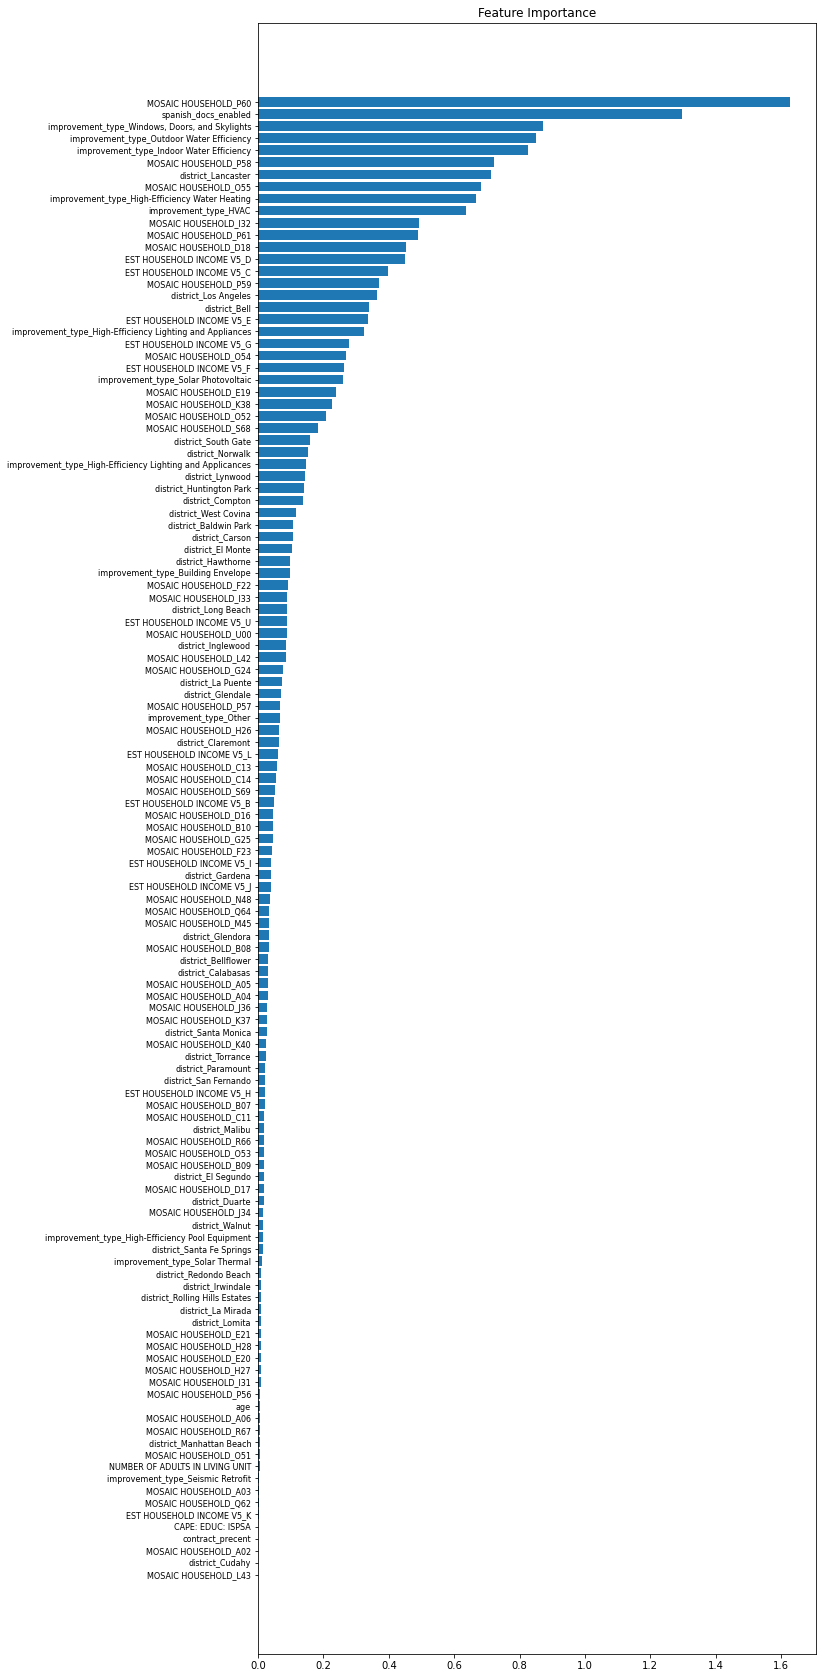

In [ ]:
feature_importance = abs(clf.coef_[0])
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.title('Feature Importance')
plt.show()

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(max_depth=3)

print(dt_model)

dt_model = dt_model.fit(X_train,y_train)
pred_dt = dt_model.predict_proba(X_test)[:, 1]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


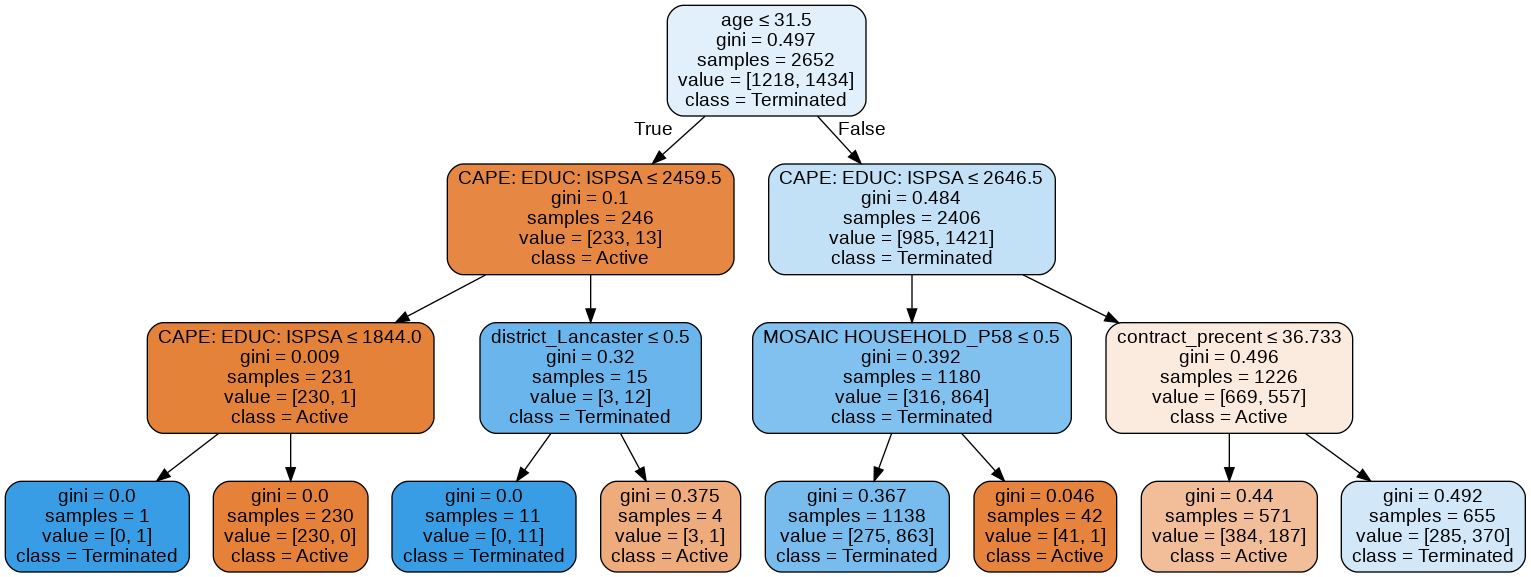

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dt_model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = X_train.columns.values.tolist(), 
               class_names=['Active', 'Terminated'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [ ]:
from sklearn.metrics import classification_report
pred_dt_binary = dt_model.predict(X_test)
print(classification_report(y_test, pred_dt_binary))

              precision    recall  f1-score   support

           0       0.79      0.51      0.62       400
           1       0.69      0.89      0.77       484

    accuracy                           0.72       884
   macro avg       0.74      0.70      0.70       884
weighted avg       0.73      0.72      0.70       884



### RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()  

print(rf_model)

rf_model.fit(X_train, y_train)  
pred_rf = rf_model.predict(X_test)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


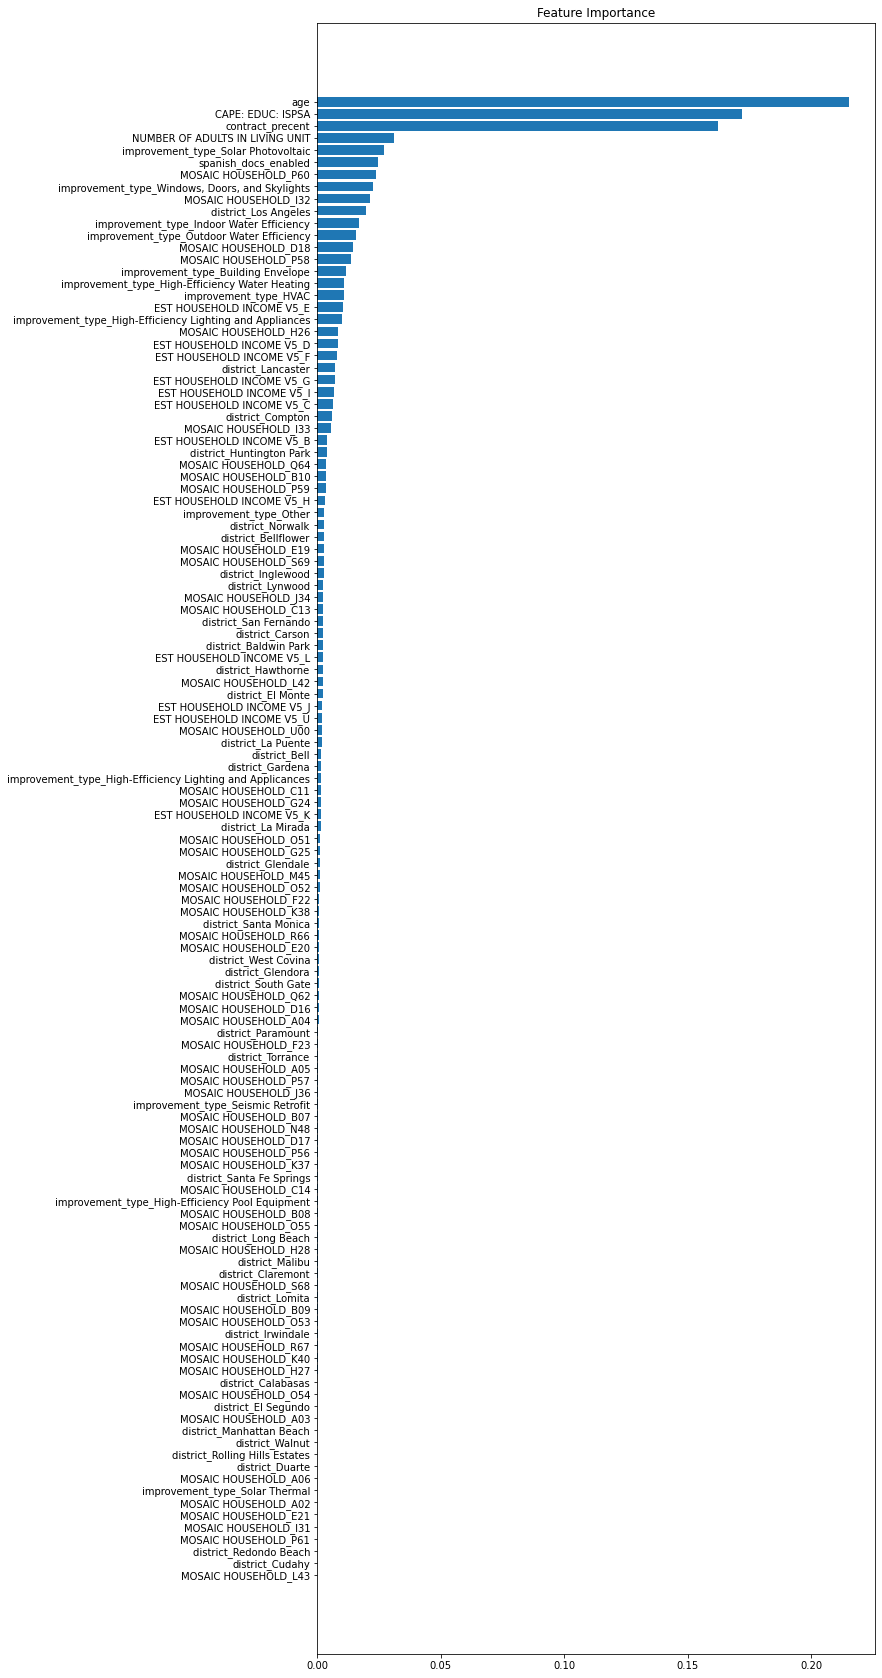

In [ ]:
feature_importance = abs(rf_model.feature_importances_)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=10)

plt.title('Feature Importance')
plt.show()

### XGBoost



In [ ]:
from xgboost import XGBClassifier


xgb_model = XGBClassifier()

print(xgb_model)

xgb_model.fit(X_train, y_train)
pred_xgb =  xgb_model.predict_proba(X_test)[:, 1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


### AUC Curve comparing all the models 

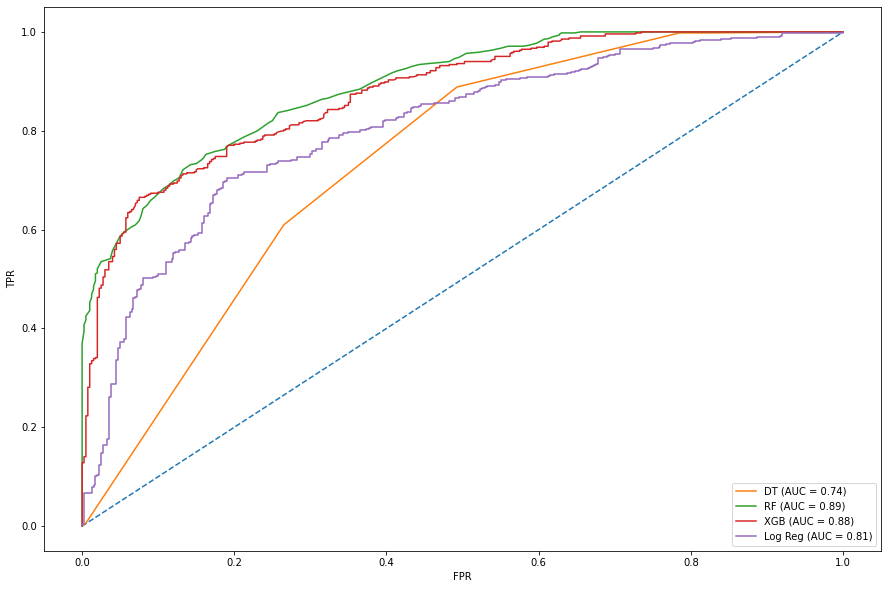

In [ ]:
# calculate scores
auc_dt = roc_auc_score(y_test, pred_dt)
auc_rf = roc_auc_score(y_test, pred_rf)
auc_xgb = roc_auc_score(y_test, pred_xgb)
auc_log_reg = roc_curve(y_test, predictions)


# calculate roc curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, pred_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, pred_xgb)
fpr, tpr, _ = roc_curve(y_test, predictions)

#fpr, tpr, _ = roc_auc_score_test, predictions)

plt.figure(figsize=(15, 10))
# plot horizontal line 
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dt, tpr_dt, label='DT (AUC = %0.2f)' % auc_dt)
plt.plot(fpr_rf, tpr_rf, label='RF (AUC = %0.2f)' % auc_rf)
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = %0.2f)' % auc_xgb)
#plt.plot(fpr, tpr, label='Log R (AUC = %0.2f)' % auc_log_reg)
plt.plot(fpr, tpr, label='Log Reg (AUC = %0.2f)' % auc)

# axis labels
plt.xlabel('FPR')
plt.ylabel('TPR')
# show the legend
plt.legend(loc='lower right')
# show the plot
plt.show()

Random Forest model shows the highest values for AUC curve. 


Data exploration based on Ramdom Forest Model


In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_valid, Y_pred)
print('AUC: ', metrics.auc(fpr, tpr))
print(classification_report(y_valid, Y_pred))
print(confusion_matrix(y_valid, Y_pred))

AUC:  0.8063064049767809
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       339
           1       0.84      0.79      0.81       404

    accuracy                           0.80       743
   macro avg       0.80      0.81      0.80       743
weighted avg       0.81      0.80      0.81       743

[[279  60]
 [ 85 319]]


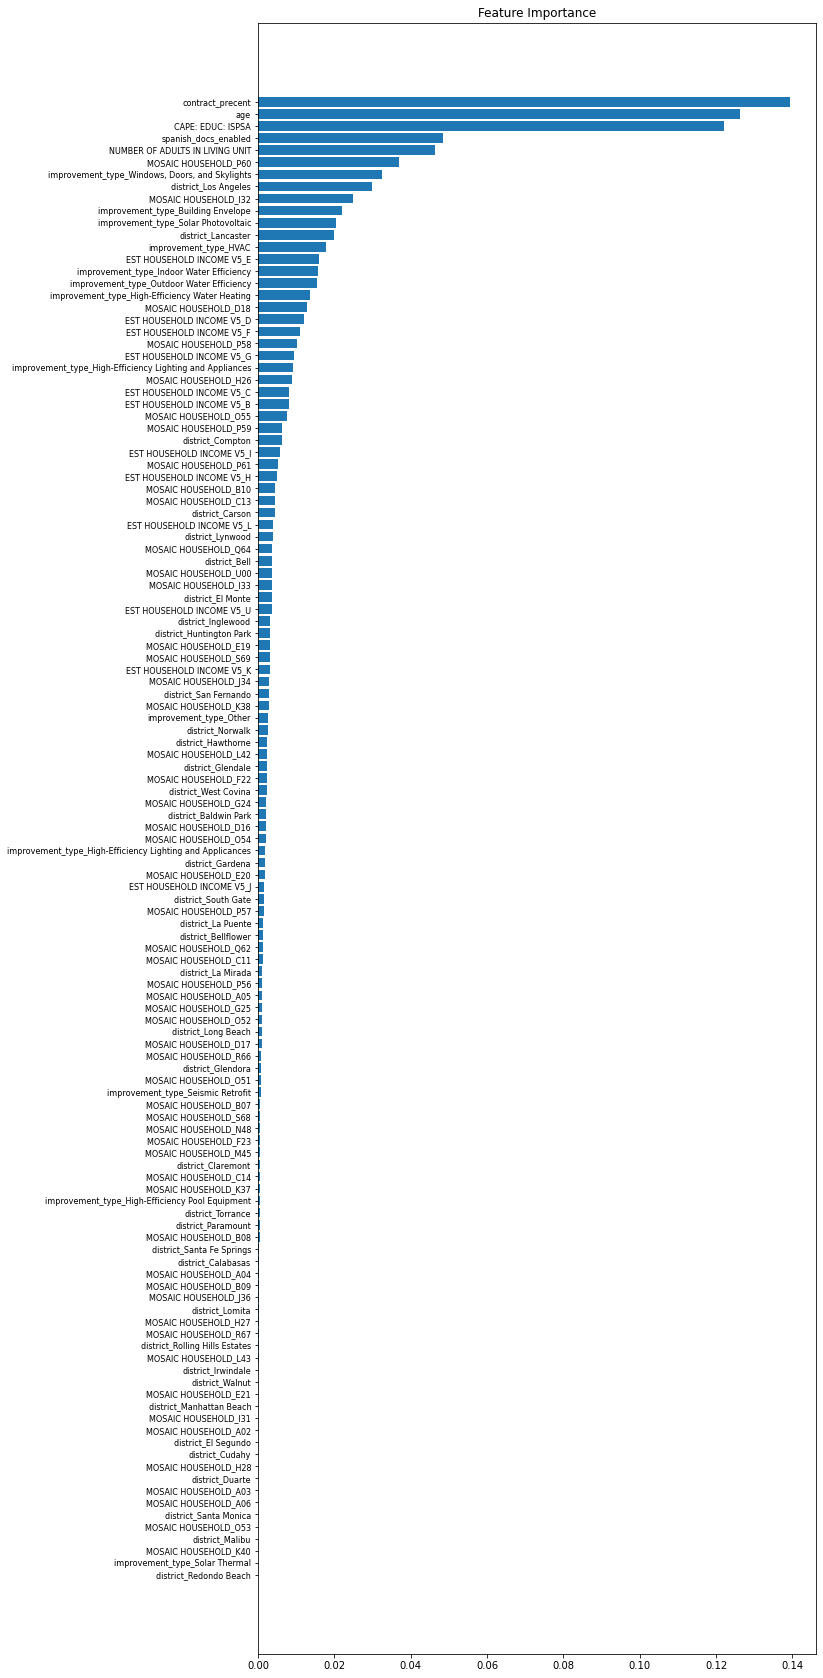

In [ ]:
feature_importance = abs(random_forest.feature_importances_)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,30))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)

plt.title('Feature Importance')
plt.show()